In [123]:
import matplotlib.pyplot as plt
import numpy as np
import ElementsEnv
from glob import glob
import itertools
import os
from tqdm.notebook import tqdm
from scipy.spatial.distance import pdist, squareform, cdist
from scipy.sparse.csgraph import minimum_spanning_tree

plt.rcParams['figure.figsize'] = (15, 5)

%erun Elements 5.12.0

os.environ['ELEMENTS_AUX_PATH'] = '/home/aalvarez/Work/Projects/PHZ_NNPZ/PHZ_NNPZ/nnpz/auxdir/'

sys.path.append('/home/aalvarez/Work/Projects/PHZ_NNPZ/PHZ_NNPZ/nnpz/python/')

%load_ext autoreload
%autoreload 2

from nnpz.photometry import DirectoryFilterProvider, FnuuJyPrePostProcessor, PhotometryCalculator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
filters_provider = DirectoryFilterProvider('/home/aalvarez/Work/Data/SC8/PHZ_Calibration_28jan21/PhosphorosRootEcdmHandler/Phosphoros/AuxiliaryData/Filters/')
filter_map = {}
filter_names = filters_provider.getFilterNames()
for filter_name in filter_names:
    filter_map[filter_name] = filters_provider.getFilterTransmission(filter_name)

In [3]:
filter_avg_trans = []
for filter_name in filter_map:
    filter_avg_trans.append(np.average(filter_map[filter_name][:,0], weights=filter_map[filter_name][:,1]))
filter_names = np.asarray(filter_names)
filter_names = filter_names[np.argsort(filter_avg_trans)]
filter_names

array(['kids/u', 'lsst/u', 'kids/g', 'lsst/g', 'des/g', 'lsst/r',
       'kids/r', 'des/r', 'euclid/VIS', 'lsst/i', 'kids/i', 'des/i',
       'lsst/z', 'des/z', 'lsst/y', 'euclid/Y', 'euclid/J', 'euclid/H'],
      dtype='<U10')

In [4]:
prepost = FnuuJyPrePostProcessor(filter_map)
calculator = PhotometryCalculator(filter_map, prepost)

In [5]:
sed_names = np.asarray([
    # O
    'uko5v', 'uko8iii', 'uko9v',
    # B
    'ukb0i', 'ukb0v', 'ukb12iii', 'ukb1i', 'ukb1v', 'ukb2ii', 'ukb2iv', 'ukb3i', 'ukb3iii',
    'ukb3v', 'ukb57v', 'ukb5i', 'ukb5ii', 'ukb5iii', 'ukb6iv', 'ukb8i', 'ukb8v', 'ukb9iii', 'ukb9v',
    # A
    'uka0i', 'uka0iii', 'uka0iv', 'uka0v', 'uka2i', 'uka2v',
    'uka3iii', 'uka3v', 'uka47iv', 'uka5iii', 'uka5v', 'uka7iii', 'uka7v',
    # F normal
    'ukf02iv', 'ukf0i', 'ukf0ii', 'ukf0iii', 'ukf0v', 'ukf2ii', 'ukf2iii',
    'ukf2v', 'ukf5i', 'ukf5iii', 'ukf5iv', 'ukf5v', 'ukf6v', 'ukf8i', 'ukf8iv', 'ukf8v',
    # F metal rich
    'ukrf6v', 'ukrf8v',
    # F metal weak,
    'ukwf5v', 'ukwf8v',
    # G normal
    'ukg0i',  'ukg0iii', 'ukg0iv', 'ukg0v', 'ukg2i', 'ukg2iv',
    'ukg2v', 'ukg5i', 'ukg5ii', 'ukg5iii', 'ukg5iv', 'ukg5v', 'ukg8i', 
    'ukg8iii',  'ukg8iv',  'ukg8v', 
    # G metal rich
    'ukrg0v', 'ukrg5iii', 'ukrg5v',
    # G metal weak
    'ukwg0v', 'ukwg5iii', 'ukwg5v', 'ukwg8iii',
    # K normal
    'ukk01ii', 'ukk0iii', 'ukk0iv', 'ukk0v', 'ukk1iii', 'ukk1iv', 
    'ukk2i', 'ukk2iii', 'ukk2v', 'ukk34ii', 'ukk3i', 'ukk3iii', 
    'ukk3iv', 'ukk3v', 'ukk4i', 'ukk4iii', 'ukk4v', 'ukk5iii', 'ukk5v', 'ukk7v', 
    # K metal rich
    'ukrk0iii', 'ukrk0v', 'ukrk1iii', 'ukrk2iii', 'ukrk3iii', 'ukrk4iii', 'ukrk5iii',
    # K metal weak
    'ukwk0iii', 'ukwk1iii', 'ukwk2iii', 'ukwk3iii', 'ukwk4iii',
    # M
    'ukm0iii', 'ukm0v', 'ukm10iii', 'ukm1iii', 'ukm1v', 'ukm2.5v', 'ukm2i', 'ukm2iii', 'ukm2v', 'ukm3ii', 'ukm3iii', 
    'ukm3v', 'ukm4iii', 'ukm4v', 'ukm5iii', 'ukm5v', 'ukm6iii', 'ukm6v', 'ukm7iii', 'ukm8iii', 'ukm9iii', 
])
len(sed_names)

131

In [6]:
seds = np.zeros((4771, len(sed_names) + 1), dtype=np.float32)
for i, sf in enumerate(tqdm(sed_names)):
    s = np.loadtxt('/home/aalvarez//Phosphoros/AuxiliaryData/SEDs/Pickles/' + sf + '.dat')
    if i == 0:
        seds[:, 0] = s[:, 0]
    seds[:, i+1] = s[:, 1]

  0%|          | 0/131 [00:00<?, ?it/s]

In [7]:
seds[:, 1:].shape

(4771, 131)

In [48]:
solar_sed = np.loadtxt('/home/aalvarez/Phosphoros/AuxiliaryData/SEDs/solar_spectrum.sed')

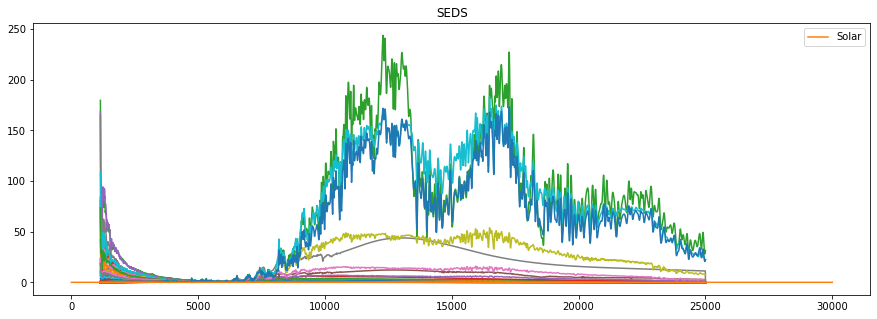

In [42]:
plt.figure()
plt.title('SEDS')
plt.plot(seds[:,0], seds[:, 1:])
plt.plot(solar_sed[:, 0], solar_sed[:, 1], label='Solar')
plt.legend()
plt.show()

# Photometry

In [9]:
dtype = calculator.compute(seds[:,0:2]).dtype
photo = np.zeros(seds.shape[1] - 1, dtype=dtype)
for i in tqdm(range(seds.shape[1]-1)):
    photo[i] = calculator.compute(seds[:, [0, i+1]])[0]

  0%|          | 0/131 [00:00<?, ?it/s]

In [10]:
bands = ['lsst/u', 'lsst/g', 'lsst/r', 'lsst/i', 'lsst/z', 'euclid/VIS', 'euclid/H']
color_names = []
for i in range(len(bands)):
    for j in range(i+1, len(bands)):
        color_names.append((bands[i], bands[j]))
pw = []
for i in range(len(color_names)):
    for j in range(i+1, len(color_names)):
        pw.append((i, j))
print(color_names, len(pw))

[('lsst/u', 'lsst/g'), ('lsst/u', 'lsst/r'), ('lsst/u', 'lsst/i'), ('lsst/u', 'lsst/z'), ('lsst/u', 'euclid/VIS'), ('lsst/u', 'euclid/H'), ('lsst/g', 'lsst/r'), ('lsst/g', 'lsst/i'), ('lsst/g', 'lsst/z'), ('lsst/g', 'euclid/VIS'), ('lsst/g', 'euclid/H'), ('lsst/r', 'lsst/i'), ('lsst/r', 'lsst/z'), ('lsst/r', 'euclid/VIS'), ('lsst/r', 'euclid/H'), ('lsst/i', 'lsst/z'), ('lsst/i', 'euclid/VIS'), ('lsst/i', 'euclid/H'), ('lsst/z', 'euclid/VIS'), ('lsst/z', 'euclid/H'), ('euclid/VIS', 'euclid/H')] 210


In [11]:
np.random.shuffle(pw)

In [12]:
colors = np.zeros((len(photo), len(color_names)))
for i, (a, b) in enumerate(color_names):
    colors[:, i] = photo[a] / photo[b]

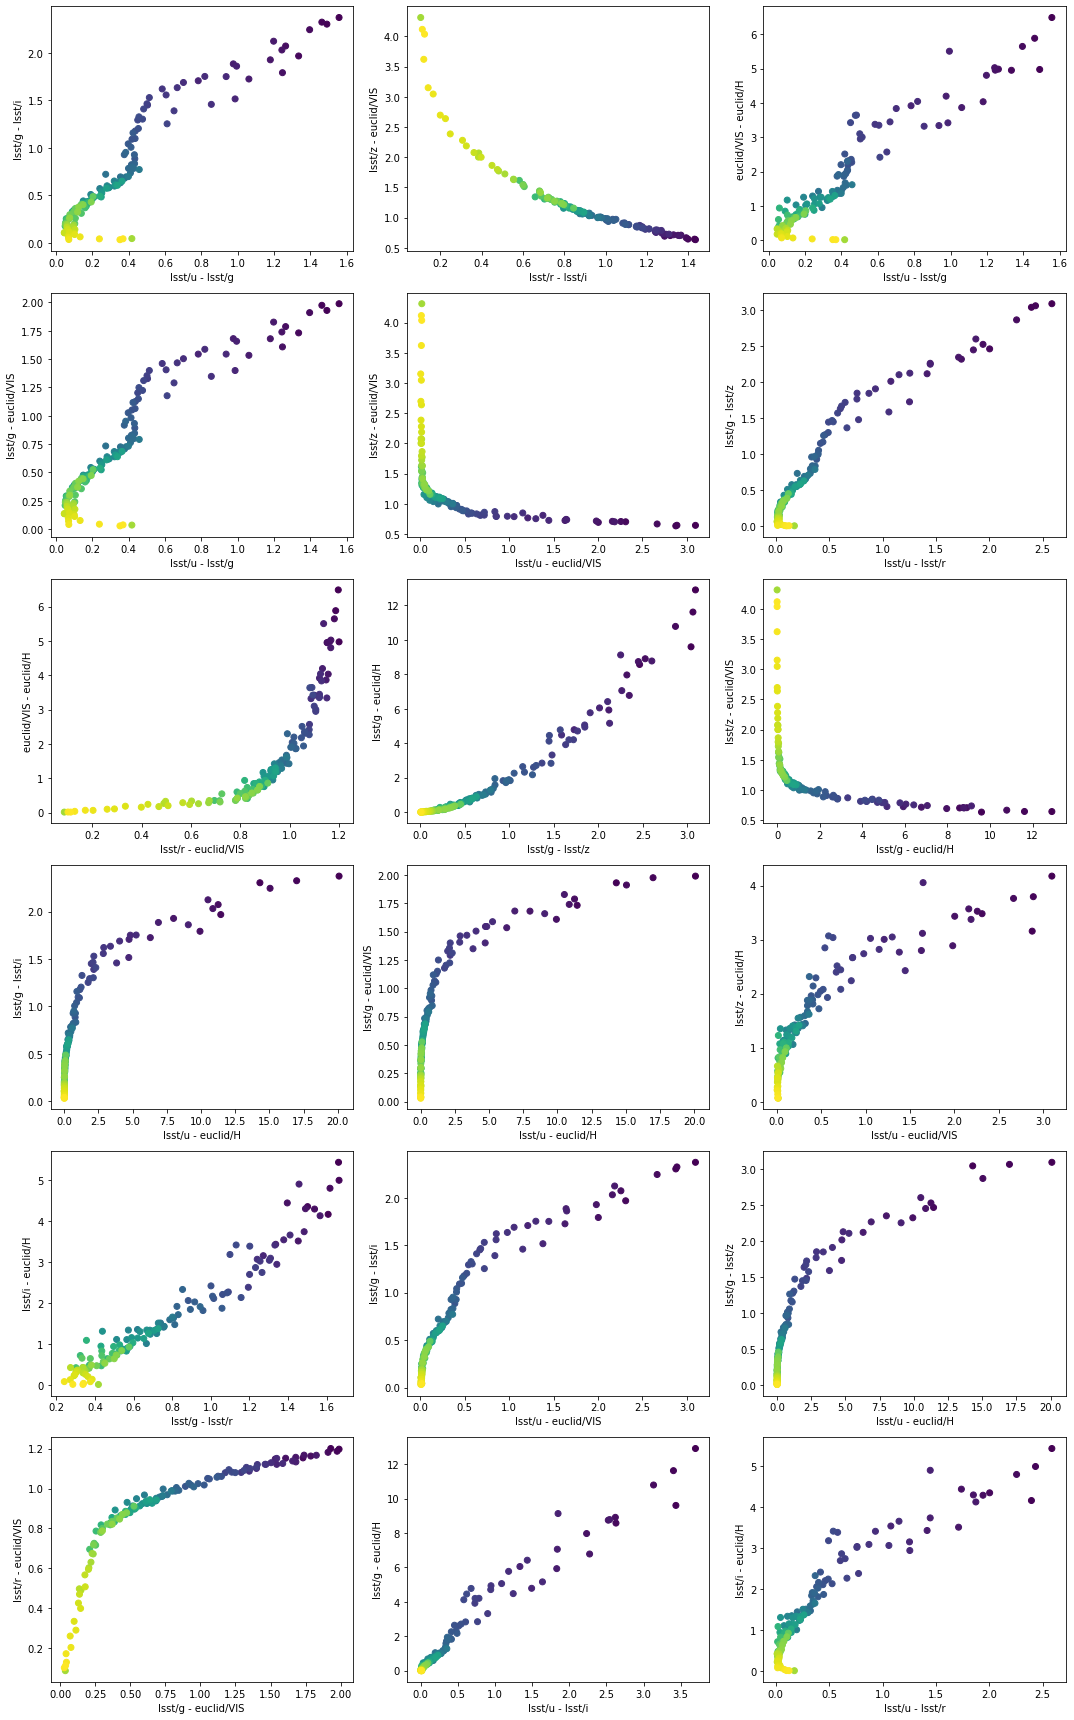

In [13]:
nrows = 6
fig, axes = plt.subplots(ncols=3, nrows=nrows, figsize=(15, 4 * nrows))

for ax, (a, b) in zip(axes.ravel(), pw):
    ax.scatter(colors[:, a], colors[:, b], c=np.arange(seds.shape[1]-1))
    ax.set_xlabel(' - '.join(color_names[a]))
    ax.set_ylabel(' - '.join(color_names[b]))
plt.tight_layout()
plt.show()

# Home-made Hertzsprung–Russell

In [338]:
solar_intensity = np.trapz(solar_sed[:, 1], x=solar_sed[:, 0])
solar_intensity *= 10**5
sed_intensity = np.trapz(seds[:, 1:], x=seds[:, 0:1], axis=0)
sed_intensity /= solar_intensity

In [339]:
print(color_names.index(('lsst/g', 'euclid/VIS')))
print(color_names.index(('lsst/u', 'lsst/g')))

9
0


In [346]:
coords = np.stack([colors[:,9], np.log10(sed_intensity)], axis=-1)
coords /= coords.max(axis=0)

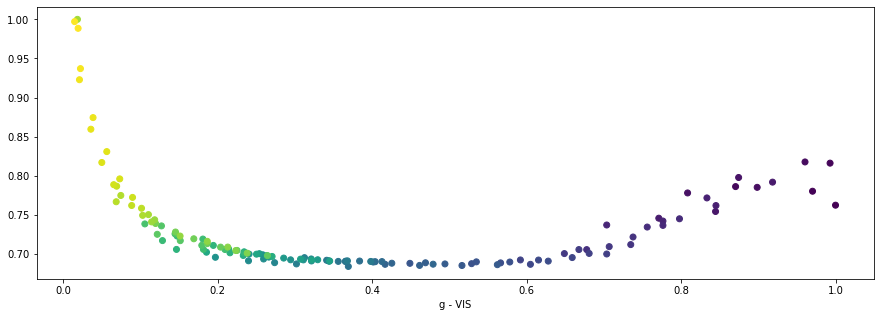

In [347]:
plt.figure()
plt.scatter(coords[:,0], coords[:,1], c=np.arange(len(sed_names)))
plt.xlabel('g - VIS')
#plt.ylabel('Intensity')
plt.show()

In [348]:
pdistances = squareform(pdist(coords))

In [349]:
conn = (minimum_spanning_tree(pdistances).toarray() > 0)

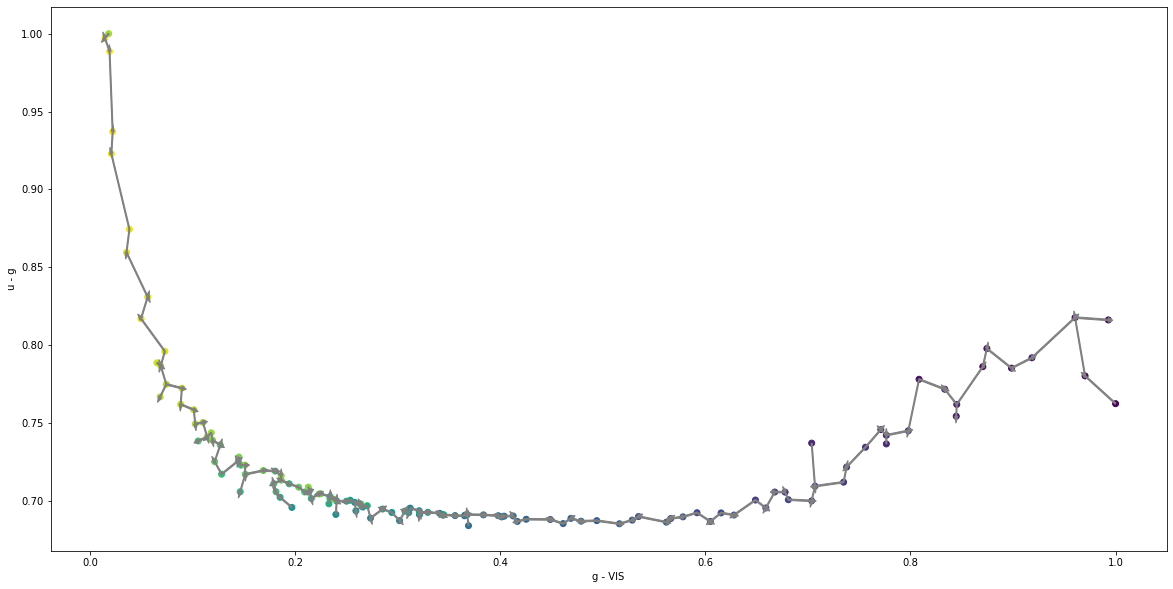

In [350]:
plt.figure(figsize=(20, 10))
plt.xlabel('g - VIS')
plt.ylabel('u - g')
plt.scatter(coords[:,0], coords[:,1], c=np.arange(len(sed_names)))

for i in range(conn.shape[0]):
    sx, sy = coords[i]
    t = np.where(conn[i])[0]
    for e in t:
        ex, ey = coords[e]
        plt.arrow(sx, sy, ex-sx, ey-sy, color='gray')

plt.show()

In [351]:
def chi2_distance(a, b):
    mask = ((a > 0) & (b >= 0)) | ((b > 0) & (a >= 0))
    return np.sum((a[mask] - b[mask])**2 / (a[mask] + b[mask])**2) / 2

In [352]:
pchi2 = squareform(pdist(seds[:, 1:].T, chi2_distance))

In [353]:
conn2 = (minimum_spanning_tree(pchi2).toarray() > 0)

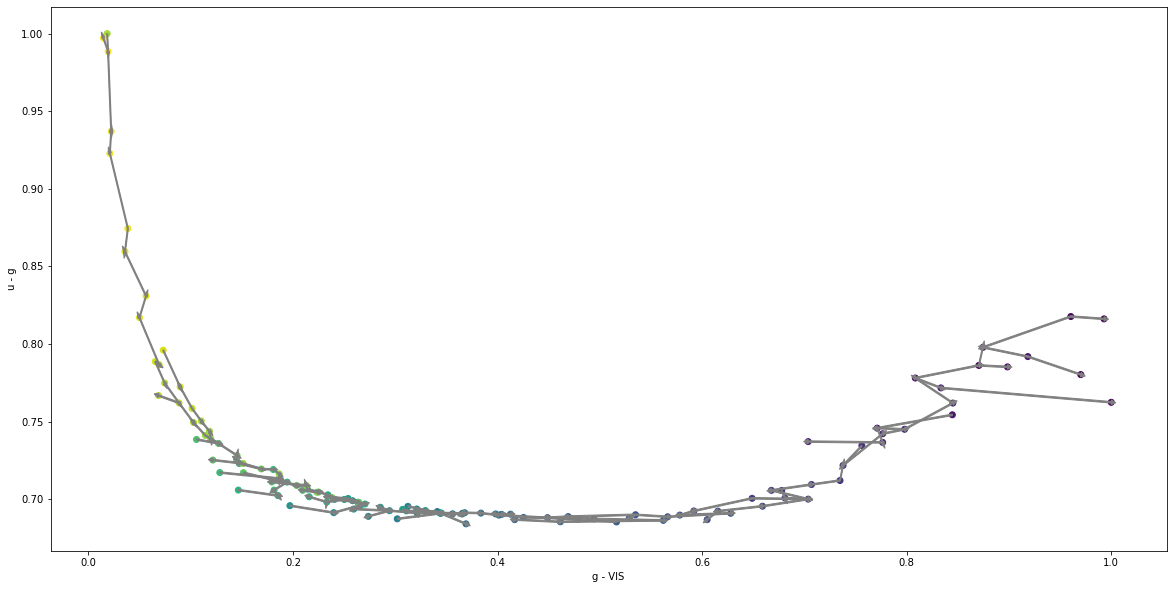

In [354]:
plt.figure(figsize=(20, 10))
plt.xlabel('g - VIS')
plt.ylabel('u - g')
plt.scatter(coords[:,0], coords[:,1], c=np.arange(len(sed_names)))

for i in range(conn.shape[0]):
    sx, sy = coords[i]
    t = np.where(conn2[i])[0]
    for e in t:
        ex, ey = coords[e]
        plt.arrow(sx, sy, ex-sx, ey-sy, color='gray')

plt.show()

In [372]:
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

In [388]:
G = nx.Graph()
for i in range(conn2.shape[0]):
    for j in range(i+1, conn2.shape[1]):
        if conn[i, j] or conn[j, i]:
            a = sed_names[i]
            b = sed_names[j]
            G.add_edge(a, b)

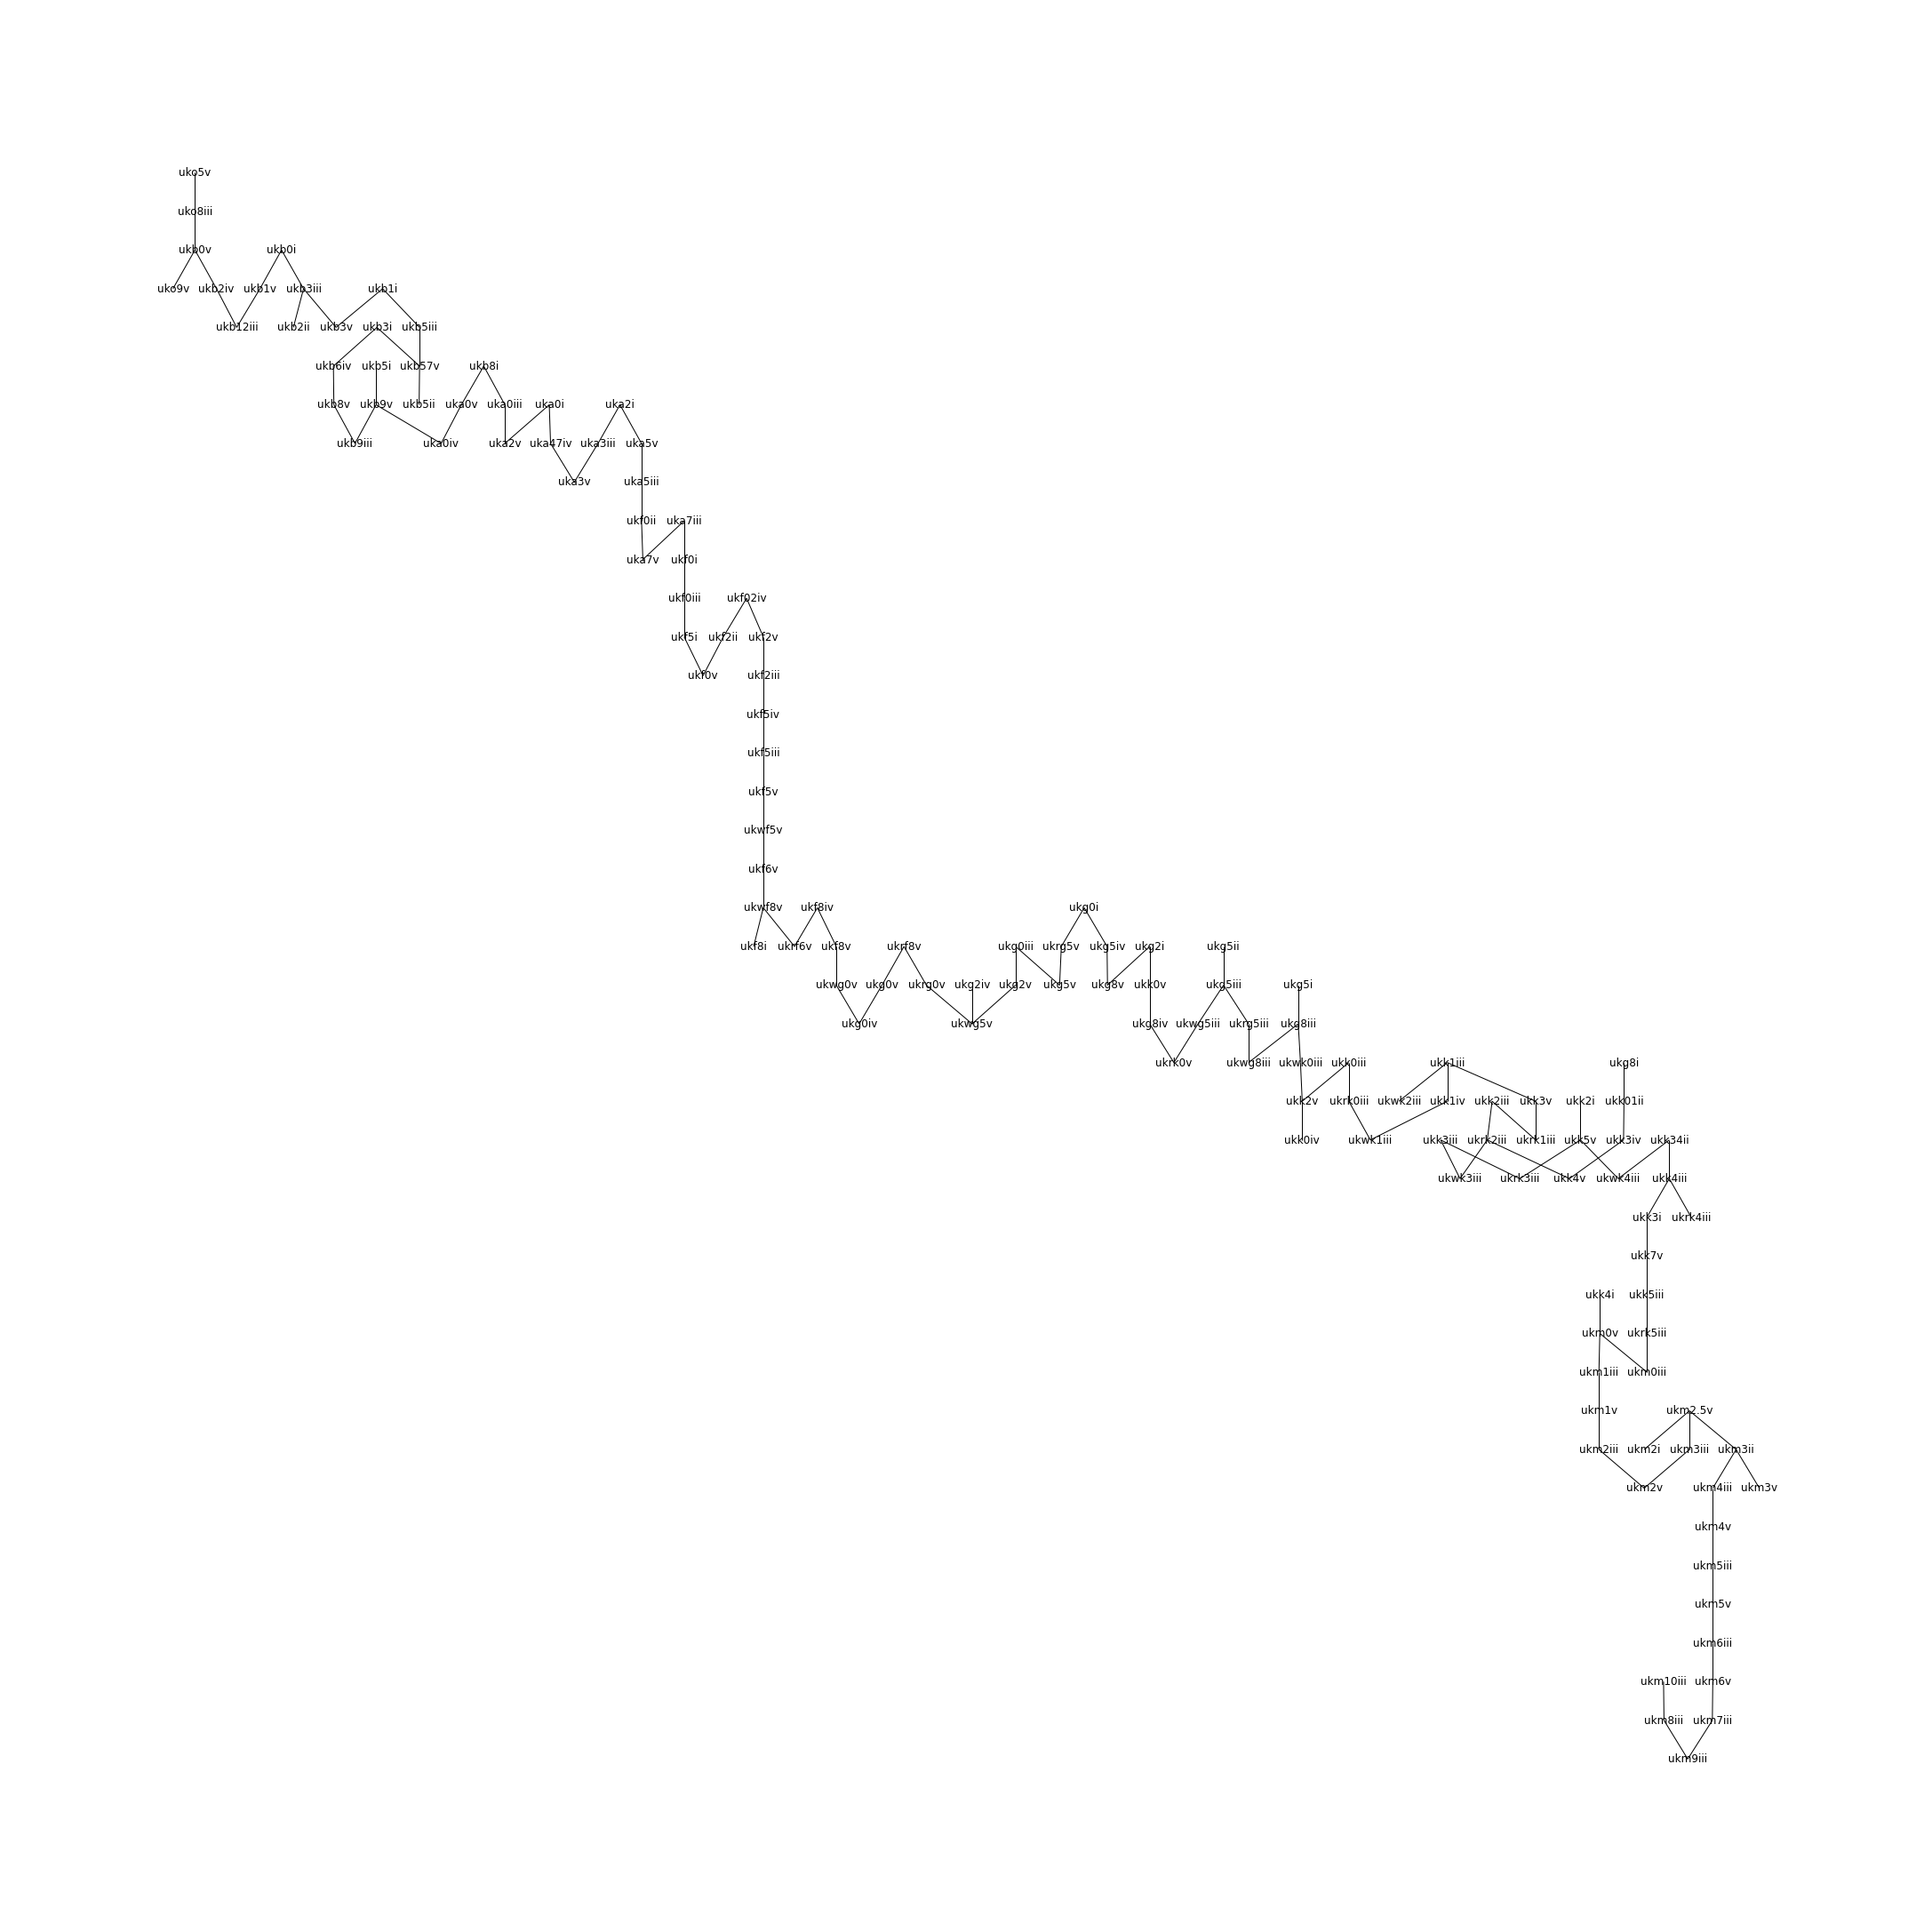

In [392]:
pos = graphviz_layout(G, prog='dot')
plt.figure(figsize=(30, 30))
nx.draw(G, pos, with_labels=True, node_size=0)
plt.savefig('/home/aalvarez/Downloads/starseds.pdf')